Deep Learning Assignment 3 - Stock Price Prediction With RNN

References:
Code source 1: https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632

Code source 2 (TODO: find how to get predictions accuracy): https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch


In [2]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import torch
import torch.nn as nn
import os
import yfinance as yf
import os, contextlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [4]:
# File Download 
offset = 0
limit = 3000
period = 'max' # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
symbols = ['AAPL','AMZN','META']
limit = limit if limit else len(symbols)
end = min(offset + limit, len(symbols))
is_valid = [False] * len(symbols)
# force silencing of verbose API
with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        for i in range(offset, end):
            s = symbols[i]
            data = yf.download(s, period=period)
            if len(data.index) == 0:
                continue
        
            is_valid[i] = True
            file_name = s + ".csv"
            # download_path = os.path.join(root_dir,file_name)
            data.to_csv(file_name)

print('Total number of valid symbols downloaded = {}'.format(sum(is_valid)))

Total number of valid symbols downloaded = 3


In [56]:
MIN_MAX_SCALING = "min_max_scaling"
STANDARD_SCALING = "standard_scaling"
ADJACENT_CLOSE = "Adj Close"
OPEN = "Open"
def get_scaler(scaling_method):
    data_scaler = None
    if scaling_method == MIN_MAX_SCALING:
        data_scaler = MinMaxScaler(feature_range=(-1, 1))
    elif scaling_method == STANDARD_SCALING:
        data_scaler = StandardScaler()
    else:
        raise Exception("Invalid Scaling method ", scaling_method)

    return data_scaler

def get_data(file_name, scaling_method):
    data = pd.read_csv(file_name, index_col='Date')
    price_close = data[[ADJACENT_CLOSE]]
    price_open = data[[OPEN]]

    data_scaler = get_scaler(scaling_method)
    
    price_close[ADJACENT_CLOSE] = data_scaler.fit_transform(price_close[ADJACENT_CLOSE].values.reshape(-1,1))
    price_open[OPEN] = data_scaler.fit_transform(price_open[OPEN].values.reshape(-1,1))

    return price_open, price_close, data_scaler


In [17]:

price_open_min_max, price_close_min_max = get_data('AMZN.csv', MIN_MAX_SCALING)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
price_open_min_max

,Open
Date,
1997-05-15,-0.999449
1997-05-16,-0.999699
1997-05-19,-0.999811
1997-05-20,-0.999827
1997-05-21,-0.999878
...,...
2022-11-10,-0.007430
2022-11-11,0.045368
2022-11-14,0.054880


In [19]:
price_close_min_max

,Adj Close
Date,
1997-05-15,-0.999698
1997-05-16,-0.999821
1997-05-19,-0.999832
1997-05-20,-0.999872
1997-05-21,-0.999983
...,...
2022-11-10,0.035494
2022-11-11,0.080105
2022-11-14,0.055441


In [20]:
price_open_standard, price_close_standard = get_data('AMZN.csv', STANDARD_SCALING)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
price_open_standard

,Open
Date,
1997-05-15,-0.638990
1997-05-16,-0.639480
1997-05-19,-0.639698
1997-05-20,-0.639731
1997-05-21,-0.639829
...,...
2022-11-10,1.301840
2022-11-11,1.405135
2022-11-14,1.423745


In [22]:
price_close_standard

,Adj Close
Date,
1997-05-15,-0.639720
1997-05-16,-0.639960
1997-05-19,-0.639982
1997-05-20,-0.640058
1997-05-21,-0.640276
...,...
2022-11-10,1.380392
2022-11-11,1.467448
2022-11-14,1.419316


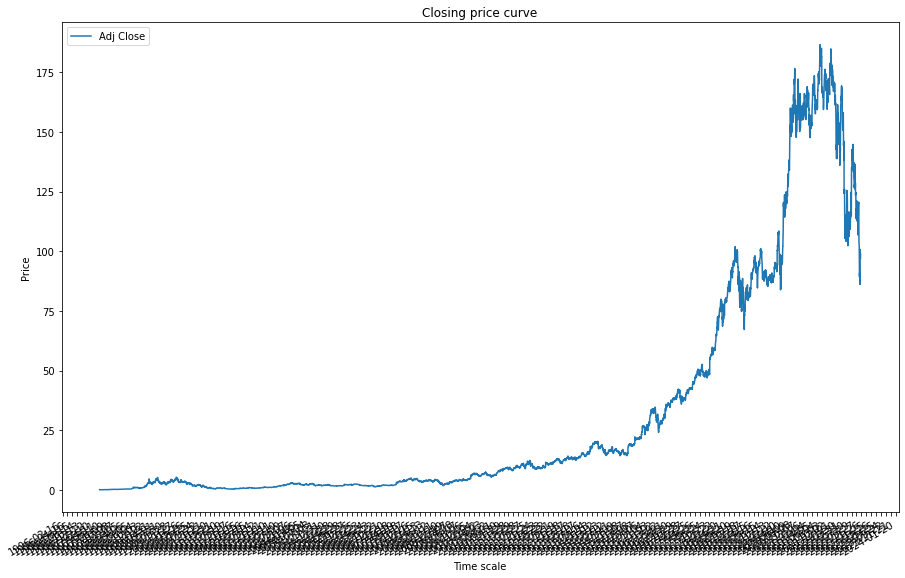

In [26]:
stock_data_raw = pd.read_csv('AMZN.csv', index_col='Date')
plt.figure(figsize=(15,10))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stock_data_raw.index.values]

plt.plot(x_dates, stock_data_raw[ADJACENT_CLOSE], label=ADJACENT_CLOSE)
# plt.plot(x_dates, data['Low'], label='Low')
plt.xlabel('Time scale')
plt.ylabel('Price')
plt.title('Closing price curve')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [30]:
def convert_to_torch_tensor(numpy_data):
    return torch.from_numpy(numpy_data).type(torch.Tensor)


def split_data(X, y, test_size, lookback):
    X_raw = X.to_numpy() # convert to numpy array
    y_raw = y.to_numpy()
    X_data = []
    y_data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(X_raw) - lookback): 
        X_data.append(X_raw[index: index + lookback])
        y_data.append(y_raw[index: index + lookback])
    
    X_data = np.array(X_data);
    y_data = np.array(y_data)
    train_set_size = X_data.shape[0] - (test_size)
    
    X_train_val = X_data[:train_set_size,:-1,:]
    y_train_val = y_data[:train_set_size,-1,:]
    
    X_test = X_data[train_set_size:,:-1]
    y_test = y_data[train_set_size:,-1,:]

    # split train into validation set
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, )

    X_train = convert_to_torch_tensor(X_train)
    X_val = convert_to_torch_tensor(X_val)
    X_test = convert_to_torch_tensor(X_test)
    y_train = convert_to_torch_tensor(y_train)
    y_val = convert_to_torch_tensor(y_val)
    y_test = convert_to_torch_tensor(y_test)
    
    return [X_train, X_val, X_test, y_train, y_val, y_test]


In [58]:
def inverse_transform_data(data, data_scaler):
    data_copy = data.clone()
    return data_scaler.inverse_transform(data_copy.detach().numpy())

def calculate_prediction_error(X, y, model, data_scaler):
    y_pred = model(X)
    #invert predictions
    y_pred_inverse = inverse_transform_data(y_pred, data_scaler)
    y_inverse = inverse_transform_data(y, data_scaler)

    mse = mean_squared_error(y_inverse[:,0], y_pred_inverse[:,0])
    rmse = math.sqrt(mse)
    return rmse



In [64]:
def train_network(num_epochs, model, criterion, optimiser, X_train, y_train, X_val, y_val, data_scaler):
    results = []
    # hist = np.zeros(num_epochs)
    start_time = time.time()
    lstm = []
    model.train()
    for t in range(num_epochs):
        y_train_pred = model(X_train)
        loss = criterion(y_train_pred, y_train)
        loss_value_train = loss.item()
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        val_loss = calculate_prediction_error(X_val, y_val, model, data_scaler)
        print("Epoch: ", t, ", Train loss: ", loss_value_train, ", Val loss: ", val_loss)
        results.append({'epoch': t, 'train_loss': loss_value_train, 'val_loss': val_loss})

    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    return results

In [76]:
def plot_loss_curve(x_values, y_values, title):
    plt.plot(x_values, y_values)
    plt.title(title + ' Loss curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss  value')
    plt.show()

def plot_training_loss_curves(train_results,  title):
    epochs = []
    train_loss_values =  []
    val_loss_values = []
    for r in train_results:
        epochs.append(r['epoch'])
        train_loss_values.append(r['train_loss'])
        val_loss_values.append(r['val_loss'])
    
    plot_loss_curve(epochs, train_loss_values, 'Train ' + title)
    plot_loss_curve(epochs, val_loss_values, 'Validation ' + title)
    
    

In [39]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.rnn(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [37]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # print('out shape ', out.shape)
        out = self.fc(out[:, -1, :]) 
        return out

In [45]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [81]:
FROM_CLOSE_TO_CLOSE = "from_close_to_close"
FROM_OPEN_TO_CLOSE = "from_open_to_close"
RNN_MODEL = "RNN_MODEL"
LSTM_MODEL = "LSTM_MODEL"
GRU_MODEL = "GRU_MODEL"

def train_model(input_dim, hidden_dim, num_layers, output_dim, num_epochs, learning_rate, lookback, model_name, file_name, test_size, 
                prediction_type, scaling_method):
    price_open, price_close, data_scaler = get_data(file_name, scaling_method)
    feature = None
    labels = price_close
    if prediction_type == FROM_CLOSE_TO_CLOSE:
        feature = price_close
        print("Choosing close as features ")
    elif prediction_type == FROM_OPEN_TO_CLOSE:
        feature = price_open
        print("Choosing open as features ")
    else:
        print("Invalid prediction type")
        raise Exception("Invalid prediction type")

    X_train, X_val, X_test, y_train, y_val, y_test = split_data(feature, labels, test_size, lookback)

    model = None
    if model_name == LSTM_MODEL:
        model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    elif model_name == GRU_MODEL:
        model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    elif model_name == RNN_MODEL:
        model = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
 
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr= learning_rate)
    train_results = train_network(num_epochs, model, criterion, optimiser, X_train, y_train, X_val, y_val, data_scaler)
    plot_training_loss_curves(train_results, model_name)

    y_test_error = calculate_prediction_error(X_test, y_test, model, data_scaler)
    y_train_error = calculate_prediction_error(X_train, y_train, model, data_scaler)
    y_val_error = calculate_prediction_error(X_val, y_val, model, data_scaler)
    return y_train_error, y_val_error, y_test_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Choosing open as features 
Epoch:  0 , Train loss:  1.0377249717712402 , Val loss:  46.074045046567434
Epoch:  1 , Train loss:  0.937240719795227 , Val loss:  43.102248584126244
Epoch:  2 , Train loss:  0.8211981654167175 , Val loss:  37.98300111923013
Epoch:  3 , Train loss:  0.638257622718811 , Val loss:  29.457729248874564
Epoch:  4 , Train loss:  0.38474494218826294 , Val loss:  21.556237060330634
Epoch:  5 , Train loss:  0.2070799171924591 , Val loss:  17.03992933948176
Epoch:  6 , Train loss:  0.12575164437294006 , Val loss:  22.117325480848294
Epoch:  7 , Train loss:  0.21419775485992432 , Val loss:  24.026688042284356
Epoch:  8 , Train loss:  0.252411425113678 , Val loss:  20.844116024709766
Epoch:  9 , Train loss:  0.1866309642791748 , Val loss:  16.85399354422185
Training time: 3.955456018447876


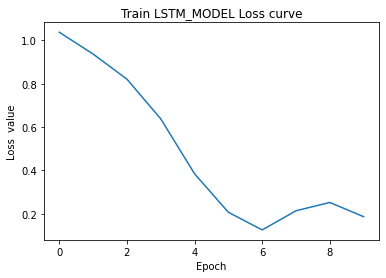

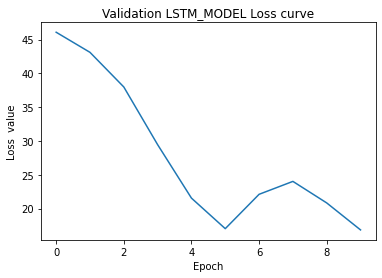

Train RMSE  16.53531820216578
Val RMSE  16.85399354422185
Test RMSE  30.7589405987562


In [77]:
# Experiment for RNN

torch.random.manual_seed(0)
input_dim = 1
# hidden_dim = 32
# num_layers = 2
output_dim = 1
# num_epochs = 10
# learning_rate = 0.01
# lookback = 15
test_size= 5

experiment_results = []
# , LSTM_MODEL, GRU_MODEL
model_names = [RNN_MODEL, LSTM_MODEL, GRU_MODEL]
file_names = ["AMZN.csv"]
# FROM_OPEN_TO_CLOSE
prediction_types = [FROM_CLOSE_TO_CLOSE]
hidden_dimensions = [8, 16, 20, 26, 32]
number_of_layers = [2,4,6,8]
number_of_epochs = [10,20,30]
lookbacks = [10,30,50,70,90]
learning_rates = [0.01, 0.001]
for file_name in file_names:
    for model_name in model_names:
        for prediction_type in prediction_types:
            for hidden_dim in hidden_dimensions:
                for num_layers in number_of_layers:
                    for num_epochs in number_of_epochs:
                        for lookback in lookbacks:
                            for learning_rate in learning_rates:
                                y_train_error, y_val_error, y_test_error = train_model(input_dim, hidden_dim, num_layers, output_dim, 
                                    num_epochs, learning_rate, lookback, model_name, file_name, test_size, prediction_type, STANDARD_SCALING)
                                
                                experiment_results.append({'input_dim':input_dim, 'hidden_dim': hidden_dim, 'num_layers': num_layers, 
                                                        'learning_rate': learning_rate, 'lookback': lookback, 'train_error': y_train_error,
                                                        'val_error': y_val_error, 'test_error': y_test_error, 'model_name': model_name, 'num_epochs': num_epochs,
                                                         'prediction_type': prediction_type })


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Choosing close as features                 Close
Date                
1997-05-15 -0.999698
1997-05-16 -0.999821
1997-05-19 -0.999832
1997-05-20 -0.999872
1997-05-21 -0.999983
...              ...
2022-11-07 -0.029921
2022-11-08 -0.035819
2022-11-09 -0.076999
2022-11-10  0.035494
2022-11-11  0.080105

[6418 rows x 1 columns]
Epoch  0 MSE:  0.9952509999275208
Epoch  1 MSE:  0.7708558440208435
Epoch  2 MSE:  0.5677278637886047
Epoch  3 MSE:  0.3386118412017822
Epoch  4 MSE:  0.1637352854013443
Epoch  5 MSE:  0.38223206996917725
Epoch  6 MSE:  0.2644254267215729
Epoch  7 MSE:  0.14517256617546082
Epoch  8 MSE:  0.12813887000083923
Epoch  9 MSE:  0.1510937660932541
Training time: 4.47037935256958


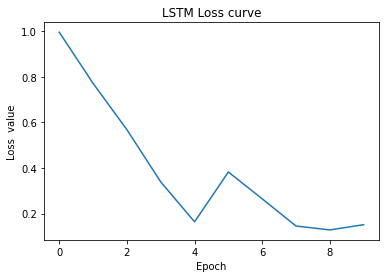

Train RMSE  37.32978458795085
Test RMSE  21.11724819636116


In [ ]:
torch.random.manual_seed(0)
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10
learning_rate = 0.01
lookback = 15
test_size= 5
train_model(hidden_dim, num_layers, output_dim, num_epochs, learning_rate, lookback, "LSTM", "AAPL.csv", test_size, "from_close_to_close")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Choosing open as features                  Open
Date                
1997-05-15 -0.999449
1997-05-16 -0.999699
1997-05-19 -0.999811
1997-05-20 -0.999827
1997-05-21 -0.999878
...              ...
2022-11-07 -0.018011
2022-11-08 -0.030408
2022-11-09 -0.044516
2022-11-10 -0.007430
2022-11-11  0.045368

[6418 rows x 1 columns]
Epoch  0 MSE:  0.7369745969772339
Epoch  1 MSE:  0.41640961170196533
Epoch  2 MSE:  0.2199297994375229
Epoch  3 MSE:  0.16164758801460266
Epoch  4 MSE:  0.1939612776041031
Epoch  5 MSE:  0.12221936881542206
Epoch  6 MSE:  0.06307707726955414
Epoch  7 MSE:  0.05187137797474861
Epoch  8 MSE:  0.044533222913742065
Epoch  9 MSE:  0.018727242946624756
Training time: 3.459454298019409


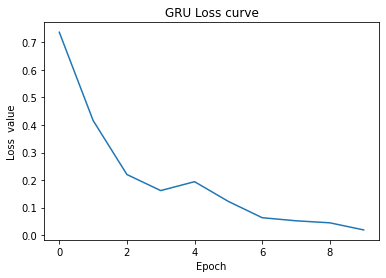

Train RMSE  6.383037511811854
Test RMSE  23.489356694675305


In [ ]:
torch.random.manual_seed(0)
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10
learning_rate = 0.01
lookback = 15
test_size= 5
train_model(hidden_dim, num_layers, output_dim, num_epochs, learning_rate, lookback, "GRU", "AAPL.csv", test_size, "from_open_to_close")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Choosing close as features                 Close
Date                
1997-05-15 -0.999698
1997-05-16 -0.999821
1997-05-19 -0.999832
1997-05-20 -0.999872
1997-05-21 -0.999983
...              ...
2022-11-07 -0.029921
2022-11-08 -0.035819
2022-11-09 -0.076999
2022-11-10  0.035494
2022-11-11  0.080105

[6418 rows x 1 columns]
Epoch  0 MSE:  0.7369849681854248
Epoch  1 MSE:  0.4163861870765686
Epoch  2 MSE:  0.21978235244750977
Epoch  3 MSE:  0.1611795574426651
Epoch  4 MSE:  0.19349516928195953
Epoch  5 MSE:  0.12172998487949371
Epoch  6 MSE:  0.0624452643096447
Epoch  7 MSE:  0.05124719440937042
Epoch  8 MSE:  0.04406679794192314
Epoch  9 MSE:  0.018515441566705704
Training time: 3.4281697273254395


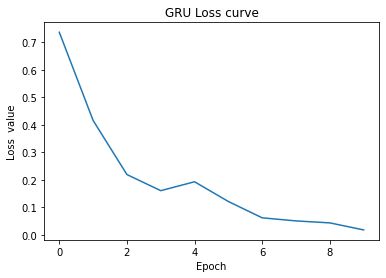

Train RMSE  6.479003740656085
Test RMSE  21.417931347427672


In [ ]:
torch.random.manual_seed(0)
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10
learning_rate = 0.01
lookback = 15
test_size= 5
train_model(hidden_dim, num_layers, output_dim, num_epochs, learning_rate, lookback, "GRU", "AAPL.csv", test_size, "from_close_to_close")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Epoch  0 MSE:  1.434052586555481
Epoch  1 MSE:  0.5905292630195618
Epoch  2 MSE:  0.19702869653701782
Epoch  3 MSE:  0.3715936243534088
Epoch  4 MSE:  0.2154933512210846
Epoch  5 MSE:  0.11113932728767395
Epoch  6 MSE:  0.1660274714231491
Epoch  7 MSE:  0.13546404242515564
Epoch  8 MSE:  0.03624818101525307
Epoch  9 MSE:  0.02865765616297722
Training time: 1.0719490051269531


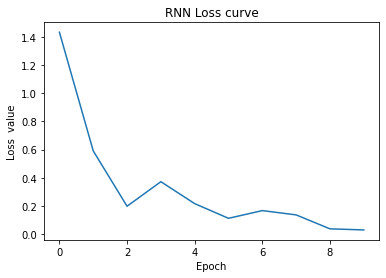

Train RMSE  27.499107762514313
Test RMSE  13.083721244228634


In [ ]:
torch.random.manual_seed(0)
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10
learning_rate = 0.01
lookback = 15
test_size= 5
train_model(hidden_dim, num_layers, output_dim, num_epochs, learning_rate, lookback, "RNN", "AAPL.csv", test_size, "from_close_to_close")


In [ ]:
# model_rnn = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
# criterion = torch.nn.MSELoss(reduction='mean')
# optimiser = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)
# train_results = train_network(num_epochs, model_rnn, criterion, optimiser, X_train, y_train)
# plot_loss_curve(train_results, 'RNN')

# y_test_pred = model_rnn(X_test)
# y_train_pred = model_rnn(X_train)
# y_test_error = calculate_prediction_error(X_test, y_test, model_rnn)
# y_train_error = calculate_prediction_error(X_train, y_train, model_rnn)
# print('Train RMSE ', y_train_error)
# print('Test RMSE ', y_test_error)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Choosing open as features                  Open
Date                
1997-05-15 -0.999449
1997-05-16 -0.999699
1997-05-19 -0.999811
1997-05-20 -0.999827
1997-05-21 -0.999878
...              ...
2022-11-07 -0.018011
2022-11-08 -0.030408
2022-11-09 -0.044516
2022-11-10 -0.007430
2022-11-11  0.045368

[6418 rows x 1 columns]
Epoch  0 MSE:  1.434052586555481
Epoch  1 MSE:  0.5905292630195618
Epoch  2 MSE:  0.19702869653701782
Epoch  3 MSE:  0.3715936243534088
Epoch  4 MSE:  0.2154933512210846
Epoch  5 MSE:  0.11113932728767395
Epoch  6 MSE:  0.1660274714231491
Epoch  7 MSE:  0.13546404242515564
Epoch  8 MSE:  0.03624818101525307
Epoch  9 MSE:  0.02865765616297722
Training time: 1.0192322731018066


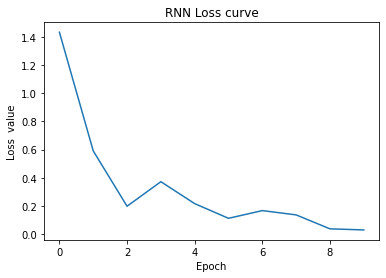

Train RMSE  27.499107762514313
Test RMSE  13.083721244228634
Choosing open as features                  Open
Date                
1997-05-15 -0.999449
1997-05-16 -0.999699
1997-05-19 -0.999811
1997-05-20 -0.999827
1997-05-21 -0.999878
...              ...
2022-11-07 -0.018011
2022-11-08 -0.030408
2022-11-09 -0.044516
2022-11-10 -0.007430
2022-11-11  0.045368

[6418 rows x 1 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Epoch  0 MSE:  0.85127854347229
Epoch  1 MSE:  0.6449048519134521
Epoch  2 MSE:  0.4017000198364258
Epoch  3 MSE:  0.1678185909986496
Epoch  4 MSE:  0.40011584758758545
Epoch  5 MSE:  0.25302332639694214
Epoch  6 MSE:  0.1345057338476181
Epoch  7 MSE:  0.1376279592514038
Epoch  8 MSE:  0.165277898311615
Epoch  9 MSE:  0.16575153172016144
Training time: 4.412065267562866


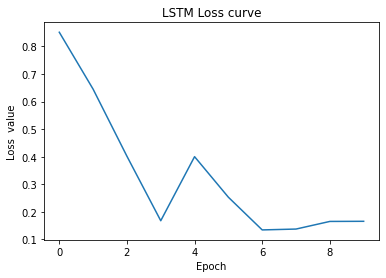

Train RMSE  34.37557172820003
Test RMSE  14.847323788536459
Choosing open as features                  Open
Date                
1997-05-15 -0.999449
1997-05-16 -0.999699
1997-05-19 -0.999811
1997-05-20 -0.999827
1997-05-21 -0.999878
...              ...
2022-11-07 -0.018011
2022-11-08 -0.030408
2022-11-09 -0.044516
2022-11-10 -0.007430
2022-11-11  0.045368

[6418 rows x 1 columns]
Epoch  0 MSE:  0.6916378140449524


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Epoch  1 MSE:  0.35289230942726135
Epoch  2 MSE:  0.17335587739944458
Epoch  3 MSE:  0.20765632390975952
Epoch  4 MSE:  0.17692211270332336
Epoch  5 MSE:  0.1035650223493576
Epoch  6 MSE:  0.08404210954904556
Epoch  7 MSE:  0.08458849042654037
Epoch  8 MSE:  0.06154971942305565
Epoch  9 MSE:  0.022370805963873863
Training time: 3.4407949447631836


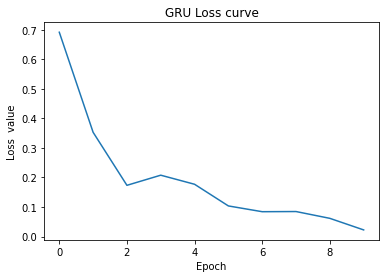

Train RMSE  7.811013530461132
Test RMSE  6.640722942751984
Choosing close as features                 Close
Date                
1997-05-15 -0.999698
1997-05-16 -0.999821
1997-05-19 -0.999832
1997-05-20 -0.999872
1997-05-21 -0.999983
...              ...
2022-11-07 -0.029921
2022-11-08 -0.035819
2022-11-09 -0.076999
2022-11-10  0.035494
2022-11-11  0.080105

[6418 rows x 1 columns]
Epoch  0 MSE:  0.5404149889945984
Epoch  1 MSE:  0.21052789688110352


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Epoch  2 MSE:  0.2796878516674042
Epoch  3 MSE:  0.0868489146232605
Epoch  4 MSE:  0.09943650662899017
Epoch  5 MSE:  0.052971046417951584
Epoch  6 MSE:  0.020874466747045517
Epoch  7 MSE:  0.0682489275932312
Epoch  8 MSE:  0.020129509270191193
Epoch  9 MSE:  0.010976677760481834
Training time: 1.0023605823516846


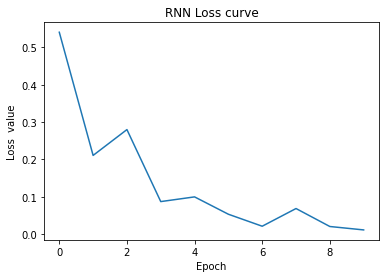

Train RMSE  17.8088143802137
Test RMSE  5.479017635199414
Choosing close as features                 Close
Date                
1997-05-15 -0.999698
1997-05-16 -0.999821
1997-05-19 -0.999832
1997-05-20 -0.999872
1997-05-21 -0.999983
...              ...
2022-11-07 -0.029921
2022-11-08 -0.035819
2022-11-09 -0.076999
2022-11-10  0.035494
2022-11-11  0.080105

[6418 rows x 1 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Epoch  0 MSE:  0.9493749737739563
Epoch  1 MSE:  0.6956301331520081
Epoch  2 MSE:  0.44807398319244385
Epoch  3 MSE:  0.22092671692371368
Epoch  4 MSE:  0.46742355823516846
Epoch  5 MSE:  0.2759271562099457
Epoch  6 MSE:  0.17702558636665344
Epoch  7 MSE:  0.19757068157196045
Epoch  8 MSE:  0.2256099134683609
Epoch  9 MSE:  0.22784002125263214
Training time: 4.4493207931518555


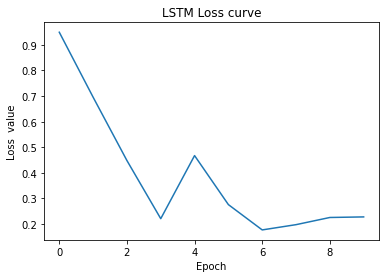

Train RMSE  42.36477654835662
Test RMSE  27.29874644772517
Choosing close as features                 Close
Date                
1997-05-15 -0.999698
1997-05-16 -0.999821
1997-05-19 -0.999832
1997-05-20 -0.999872
1997-05-21 -0.999983
...              ...
2022-11-07 -0.029921
2022-11-08 -0.035819
2022-11-09 -0.076999
2022-11-10  0.035494
2022-11-11  0.080105

[6418 rows x 1 columns]
Epoch  0 MSE:  0.5637863874435425


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Epoch  1 MSE:  0.2411048710346222
Epoch  2 MSE:  0.12194901704788208
Epoch  3 MSE:  0.210515558719635
Epoch  4 MSE:  0.10680652409791946
Epoch  5 MSE:  0.05337477847933769
Epoch  6 MSE:  0.06404466181993484
Epoch  7 MSE:  0.06692046672105789
Epoch  8 MSE:  0.03880416974425316
Epoch  9 MSE:  0.0050926352851092815
Training time: 3.4300765991210938


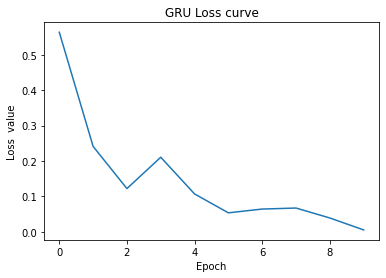

Train RMSE  11.603357000314944
Test RMSE  17.34064759696221


In [ ]:
torch.random.manual_seed(0)
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10
learning_rate = 0.01
lookback = 15
test_size= 5

model_names = ["RNN", "LSTM", "GRU"]
prediction_types = ["from_open_to_close", "from_close_to_close"]
file_names = ["AAPL.csv"]
for file_name in file_names:
    for prediction_type in prediction_types:
        for model_name in model_names:
            train_model(hidden_dim, num_layers, output_dim, num_epochs, learning_rate, lookback, model_name, file_name, test_size, prediction_type)




Learning rate =  0.1
Epoch  0 MSE:  0.6237923502922058
Epoch  1 MSE:  0.19131729006767273
Epoch  2 MSE:  1.3117761611938477
Epoch  3 MSE:  1.8092821836471558
Epoch  4 MSE:  16.227157592773438
Epoch  5 MSE:  4.188508033752441
Epoch  6 MSE:  3.702991485595703
Epoch  7 MSE:  0.8751067519187927
Epoch  8 MSE:  0.031794071197509766
Epoch  9 MSE:  0.9290366768836975
Epoch  10 MSE:  0.14129604399204254
Epoch  11 MSE:  0.36101821064949036
Epoch  12 MSE:  0.3529793322086334
Epoch  13 MSE:  0.14915043115615845
Epoch  14 MSE:  0.018736127763986588
Training time: 1.326542854309082


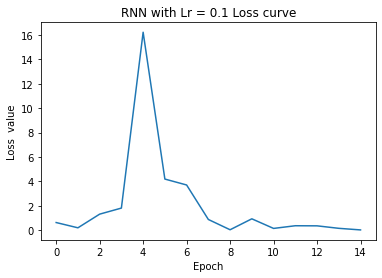

Learning rate =  0.01
Epoch  0 MSE:  0.8503121137619019
Epoch  1 MSE:  0.1647813320159912
Epoch  2 MSE:  0.07499711215496063
Epoch  3 MSE:  0.14747704565525055
Epoch  4 MSE:  0.042528558522462845
Epoch  5 MSE:  0.023443715646862984
Epoch  6 MSE:  0.07366373389959335
Epoch  7 MSE:  0.05217595398426056
Epoch  8 MSE:  0.018820788711309433
Epoch  9 MSE:  0.014899840578436852
Epoch  10 MSE:  0.027675561606884003
Epoch  11 MSE:  0.03476564213633537
Epoch  12 MSE:  0.029222644865512848
Epoch  13 MSE:  0.01888645999133587
Epoch  14 MSE:  0.014045601710677147
Training time: 1.35099458694458


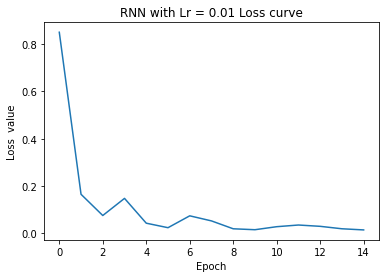

Learning rate =  0.001
Epoch  0 MSE:  0.643222987651825
Epoch  1 MSE:  0.5502309799194336
Epoch  2 MSE:  0.46130266785621643
Epoch  3 MSE:  0.3771834373474121
Epoch  4 MSE:  0.29895704984664917
Epoch  5 MSE:  0.22779373824596405
Epoch  6 MSE:  0.16493239998817444
Epoch  7 MSE:  0.11163210868835449
Epoch  8 MSE:  0.06910736113786697
Epoch  9 MSE:  0.038351837545633316
Epoch  10 MSE:  0.01981860026717186
Epoch  11 MSE:  0.013013855554163456
Epoch  12 MSE:  0.016120346263051033
Epoch  13 MSE:  0.02587137743830681
Epoch  14 MSE:  0.038054365664720535
Training time: 1.3220300674438477


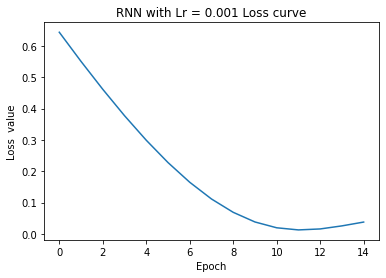

Learning rate =  0.0001
Epoch  0 MSE:  0.8532350659370422
Epoch  1 MSE:  0.8449146747589111
Epoch  2 MSE:  0.8366148471832275
Epoch  3 MSE:  0.8283364176750183
Epoch  4 MSE:  0.8200799822807312
Epoch  5 MSE:  0.8118460178375244
Epoch  6 MSE:  0.8036348223686218
Epoch  7 MSE:  0.7954465746879578
Epoch  8 MSE:  0.7872812747955322
Epoch  9 MSE:  0.7791388630867004
Epoch  10 MSE:  0.7710191011428833
Epoch  11 MSE:  0.7629218101501465
Epoch  12 MSE:  0.75484699010849
Epoch  13 MSE:  0.7467945218086243
Epoch  14 MSE:  0.7387641668319702
Training time: 1.615807056427002


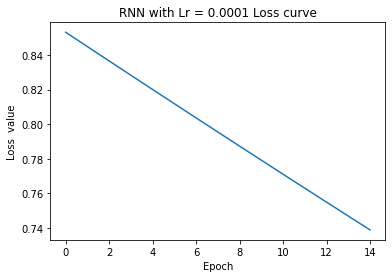

,lr,mse,train_results
1,0.0100,0.014046,"[{'epoch': 0, 'train_loss': 0.8503121137619019..."
0,0.1000,0.018736,"[{'epoch': 0, 'train_loss': 0.6237923502922058..."
2,0.0010,0.038054,"[{'epoch': 0, 'train_loss': 0.643222987651825}..."
3,0.0001,0.738764,"[{'epoch': 0, 'train_loss': 0.8532350659370422..."


In [ ]:
# Learning rate tuning for RNN model
num_epochs = 15
lr_results = []
for lr in [0.1, 0.01,  0.001,  0.0001]:
    print('Learning rate = ', lr)
    model_rnn = RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model_rnn.parameters(), lr=lr)
    train_results = train_network(num_epochs, model_rnn, criterion, optimiser, X_train, y_train)
    plot_loss_curve(train_results, 'RNN with Lr = ' + str(lr))
    # get last mse
    last_mse = [result['train_loss'] for result in  train_results if result['epoch']  == num_epochs  - 1][0]
    lr_results.append({'lr': lr, 'mse': last_mse, 'train_results': train_results})

lr_results_df = pd.DataFrame(lr_results)
lr_results_df.sort_values(by="mse", ascending=True)

Learning rate =  0.1
Epoch  0 MSE:  0.6374721527099609
Epoch  1 MSE:  3.8876919746398926
Epoch  2 MSE:  0.42325645685195923
Epoch  3 MSE:  0.16160467267036438
Epoch  4 MSE:  0.017067817971110344
Epoch  5 MSE:  0.13153016567230225
Epoch  6 MSE:  0.15794220566749573
Epoch  7 MSE:  0.0904245674610138
Epoch  8 MSE:  0.033697694540023804
Epoch  9 MSE:  0.018288280814886093
Epoch  10 MSE:  0.03612056374549866
Epoch  11 MSE:  0.025734934955835342
Epoch  12 MSE:  0.015559181571006775
Epoch  13 MSE:  0.02320137619972229
Epoch  14 MSE:  0.027265887707471848
Training time: 6.460925102233887


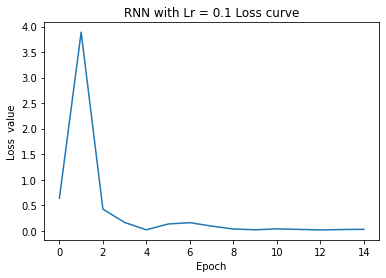

Learning rate =  0.01
Epoch  0 MSE:  0.9336367845535278
Epoch  1 MSE:  0.7188867926597595
Epoch  2 MSE:  0.48173537850379944
Epoch  3 MSE:  0.1771538406610489
Epoch  4 MSE:  0.0217445008456707
Epoch  5 MSE:  0.17766322195529938
Epoch  6 MSE:  0.12094473838806152
Epoch  7 MSE:  0.041792336851358414
Epoch  8 MSE:  0.014380949549376965
Epoch  9 MSE:  0.024752506986260414
Epoch  10 MSE:  0.04261203110218048
Epoch  11 MSE:  0.051646530628204346
Epoch  12 MSE:  0.05037369206547737
Epoch  13 MSE:  0.0424702912569046
Epoch  14 MSE:  0.03218156844377518
Training time: 6.866665840148926


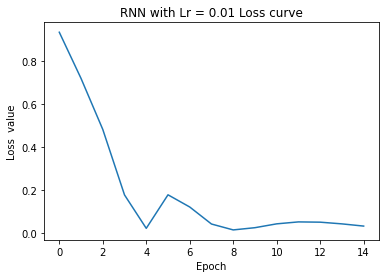

Learning rate =  0.001
Epoch  0 MSE:  0.5069724917411804
Epoch  1 MSE:  0.48562705516815186
Epoch  2 MSE:  0.46468356251716614
Epoch  3 MSE:  0.4438899755477905
Epoch  4 MSE:  0.4231257438659668
Epoch  5 MSE:  0.40230509638786316
Epoch  6 MSE:  0.3813389837741852
Epoch  7 MSE:  0.36014050245285034
Epoch  8 MSE:  0.3386298418045044
Epoch  9 MSE:  0.31673380732536316
Epoch  10 MSE:  0.2943846583366394
Epoch  11 MSE:  0.2715209424495697
Epoch  12 MSE:  0.24809333682060242
Epoch  13 MSE:  0.22407427430152893
Epoch  14 MSE:  0.19947239756584167
Training time: 7.149503469467163


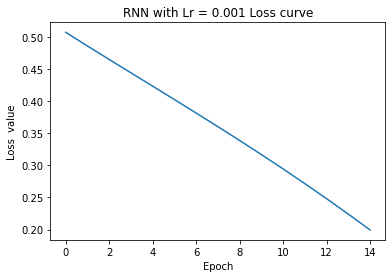

Learning rate =  0.0001
Epoch  0 MSE:  0.8745563626289368
Epoch  1 MSE:  0.8714807033538818
Epoch  2 MSE:  0.8684088587760925
Epoch  3 MSE:  0.8653407692909241
Epoch  4 MSE:  0.8622762560844421
Epoch  5 MSE:  0.8592153191566467
Epoch  6 MSE:  0.8561579585075378
Epoch  7 MSE:  0.8531038761138916
Epoch  8 MSE:  0.8500526547431946
Epoch  9 MSE:  0.847004234790802
Epoch  10 MSE:  0.8439580798149109
Epoch  11 MSE:  0.840913712978363
Epoch  12 MSE:  0.8378707766532898
Epoch  13 MSE:  0.834828794002533
Epoch  14 MSE:  0.8317872881889343
Training time: 7.045902490615845


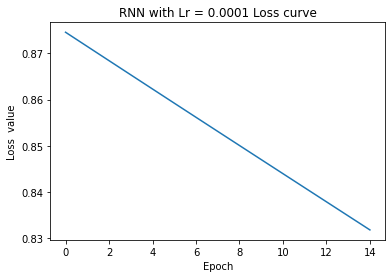

,lr,mse,train_results
0,0.1000,0.027266,"[{'epoch': 0, 'train_loss': 0.6374721527099609..."
1,0.0100,0.032182,"[{'epoch': 0, 'train_loss': 0.9336367845535278..."
2,0.0010,0.199472,"[{'epoch': 0, 'train_loss': 0.5069724917411804..."
3,0.0001,0.831787,"[{'epoch': 0, 'train_loss': 0.8745563626289368..."


In [ ]:
# Learning rate tuning for LSTM model
num_epochs = 15
lr_results = []
for lr in [0.1, 0.01,  0.001,  0.0001]:
    print('Learning rate = ', lr)
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    train_results = train_network(num_epochs, model, criterion, optimiser, X_train, y_train)
    plot_loss_curve(train_results, 'RNN with Lr = ' + str(lr))
    # get last mse
    last_mse = [result['train_loss'] for result in  train_results if result['epoch']  == num_epochs  - 1][0]
    lr_results.append({'lr': lr, 'mse': last_mse, 'train_results': train_results})

lr_results_df = pd.DataFrame(lr_results)
lr_results_df.sort_values(by="mse", ascending=True)

Learning rate =  0.1
Epoch  0 MSE:  0.7806419134140015
Epoch  1 MSE:  3.502342462539673
Epoch  2 MSE:  1.1534231901168823
Epoch  3 MSE:  0.37238264083862305
Epoch  4 MSE:  0.9952492117881775
Epoch  5 MSE:  10.697014808654785
Epoch  6 MSE:  2.2529854774475098
Epoch  7 MSE:  0.5570039749145508
Epoch  8 MSE:  0.23643165826797485
Epoch  9 MSE:  0.09453309327363968
Epoch  10 MSE:  0.3646044433116913
Epoch  11 MSE:  0.09227915853261948
Epoch  12 MSE:  0.027337877079844475
Epoch  13 MSE:  0.08142167329788208
Epoch  14 MSE:  0.02586216852068901
Training time: 5.804396629333496


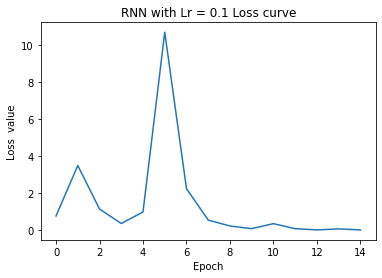

Learning rate =  0.01
Epoch  0 MSE:  0.7991613149642944
Epoch  1 MSE:  0.3235669434070587
Epoch  2 MSE:  0.03624558821320534
Epoch  3 MSE:  0.12719948589801788
Epoch  4 MSE:  0.12339473515748978
Epoch  5 MSE:  0.029202546924352646
Epoch  6 MSE:  0.01415292639285326
Epoch  7 MSE:  0.04637475684285164
Epoch  8 MSE:  0.06569038331508636
Epoch  9 MSE:  0.05889494717121124
Epoch  10 MSE:  0.03788845241069794
Epoch  11 MSE:  0.01806235872209072
Epoch  12 MSE:  0.0099750692024827
Epoch  13 MSE:  0.015131916850805283
Epoch  14 MSE:  0.025664072483778
Training time: 5.531306028366089


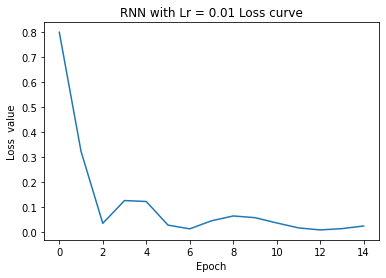

Learning rate =  0.001
Epoch  0 MSE:  0.594494640827179
Epoch  1 MSE:  0.5424798727035522
Epoch  2 MSE:  0.492352694272995
Epoch  3 MSE:  0.44408655166625977
Epoch  4 MSE:  0.397643506526947
Epoch  5 MSE:  0.35298576951026917
Epoch  6 MSE:  0.31007784605026245
Epoch  7 MSE:  0.2689223885536194
Epoch  8 MSE:  0.22958435118198395
Epoch  9 MSE:  0.19220277667045593
Epoch  10 MSE:  0.1570008099079132
Epoch  11 MSE:  0.12429648637771606
Epoch  12 MSE:  0.09451089054346085
Epoch  13 MSE:  0.06816988438367844
Epoch  14 MSE:  0.045892003923654556
Training time: 5.132084608078003


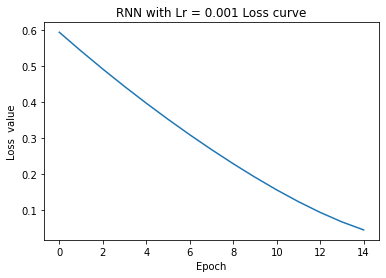

Learning rate =  0.0001
Epoch  0 MSE:  1.2418826818466187
Epoch  1 MSE:  1.2337037324905396
Epoch  2 MSE:  1.2255606651306152
Epoch  3 MSE:  1.217454195022583
Epoch  4 MSE:  1.2093846797943115
Epoch  5 MSE:  1.2013527154922485
Epoch  6 MSE:  1.193358063697815
Epoch  7 MSE:  1.1854013204574585
Epoch  8 MSE:  1.1774823665618896
Epoch  9 MSE:  1.1696007251739502
Epoch  10 MSE:  1.1617565155029297
Epoch  11 MSE:  1.15394926071167
Epoch  12 MSE:  1.1461783647537231
Epoch  13 MSE:  1.1384433507919312
Epoch  14 MSE:  1.1307436227798462
Training time: 5.061620235443115


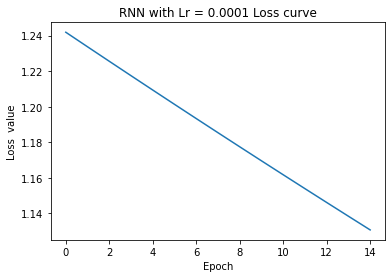

,lr,mse,train_results
1,0.0100,0.025664,"[{'epoch': 0, 'train_loss': 0.7991613149642944..."
0,0.1000,0.025862,"[{'epoch': 0, 'train_loss': 0.7806419134140015..."
2,0.0010,0.045892,"[{'epoch': 0, 'train_loss': 0.594494640827179}..."
3,0.0001,1.130744,"[{'epoch': 0, 'train_loss': 1.2418826818466187..."


In [ ]:
# Learning rate tuning for GRU model
num_epochs = 15
lr_results = []
for lr in [0.1, 0.01,  0.001,  0.0001]:
    print('Learning rate = ', lr)
    model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    train_results = train_network(num_epochs, model, criterion, optimiser, X_train, y_train)
    plot_loss_curve(train_results, 'RNN with Lr = ' + str(lr))
    # get last mse
    last_mse = [result['train_loss'] for result in  train_results if result['epoch']  == num_epochs  - 1][0]
    lr_results.append({'lr': lr, 'mse': last_mse, 'train_results': train_results})

lr_results_df = pd.DataFrame(lr_results)
lr_results_df.sort_values(by="mse", ascending=True)

In [ ]:
r = []
r.append({'epoch':1,  'val':  123})
r.append({'epoch':2, 'val': 43})

last_r = [rval['val']  for rval in r if rval['epoch'] == 2]
last_r[0]

43